In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

# --- Hyperparameters & Configuration ---
CONFIG = {
    'seed': 42,
    'learning_rate': 0.01,
    'epochs': 1000,
    'batch_size': 32,
    'l2_lambda': 0.001,       # Regularization strength
    'lr_decay': 0.95,         # Learning rate decay factor
    'lr_decay_step': 50,      # Decay every N epochs
    'bottleneck_dim': 2       # Dimension of the latent space
}

# Set global seed
np.random.seed(CONFIG['seed'])
print("Configuration loaded.")

Configuration loaded.


In [2]:
# 1. Load Dataset
data = load_breast_cancer()
X_raw = data.data
y = data.target
feature_names = data.feature_names

print(f"Dataset loaded. Shape: {X_raw.shape}")

# 2. Handle Missing Values (Imputation with Mean)
# Note: This dataset usually doesn't have missing values, but we implement the check as requested.
if np.isnan(X_raw).any():
    print("Missing values detected. Imputing with column means...")
    col_mean = np.nanmean(X_raw, axis=0)
    inds = np.where(np.isnan(X_raw))
    X_raw[inds] = np.take(col_mean, inds[1])
else:
    print("No missing values found.")

# 3. Standardization (Z-score Normalization) implementation
class StandardScalerNumPy:
    def __init__(self):
        self.mean = None
        self.std = None
    
    def fit_transform(self, X):
        self.mean = np.mean(X, axis=0)
        self.std = np.std(X, axis=0)
        # Add epsilon to avoid division by zero
        self.std[self.std == 0] = 1e-8
        return (X - self.mean) / self.std

    def inverse_transform(self, X_scaled):
        return (X_scaled * self.std) + self.mean

# Apply Normalization
scaler = StandardScalerNumPy()
X_scaled = scaler.fit_transform(X_raw)

print("Data standardized successfully.")

Dataset loaded. Shape: (569, 30)
No missing values found.
Data standardized successfully.


PCA Explained Variance Ratio: [0.44272026 0.18971182]
PCA Reconstruction Error (MSE): 0.36757


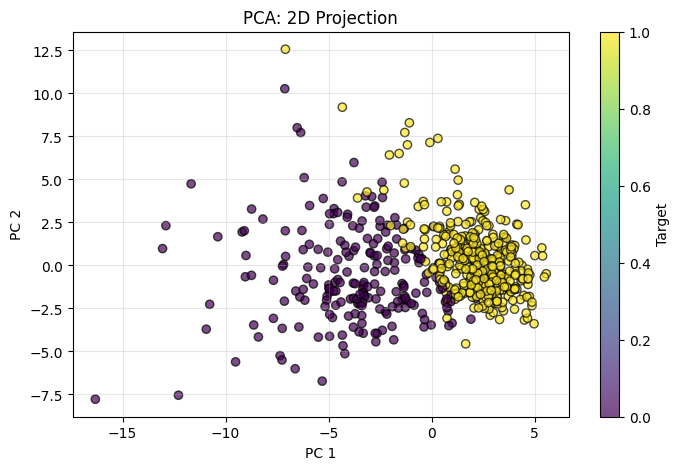

In [3]:
class PCA_Manual:
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio = None
        
    def fit(self, X):
        # 1. Center the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # 2. Compute Covariance Matrix
        # Unbiased estimator (n-1)
        n_samples = X.shape[0]
        cov_matrix = np.dot(X_centered.T, X_centered) / (n_samples - 1)
        
        # 3. Eigen Decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        # 4. Sort by eigenvalues (descending)
        idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idx]
        eigenvectors = eigenvectors[:, idx]
        
        # 5. Store results
        self.components = eigenvectors[:, :self.n_components]
        total_variance = np.sum(eigenvalues)
        self.explained_variance_ratio = eigenvalues[:self.n_components] / total_variance
        
    def transform(self, X):
        X_centered = X - self.mean
        return np.dot(X_centered, self.components)
    
    def inverse_transform(self, X_transformed):
        return np.dot(X_transformed, self.components.T) + self.mean
    
    def reconstruction_error(self, X):
        X_pca = self.transform(X)
        X_recon = self.inverse_transform(X_pca)
        return np.mean((X - X_recon) ** 2)

# --- Execute PCA ---
pca = PCA_Manual(n_components=2)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)

print(f"PCA Explained Variance Ratio: {pca.explained_variance_ratio}")
print(f"PCA Reconstruction Error (MSE): {pca.reconstruction_error(X_scaled):.5f}")

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA: 2D Projection')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.colorbar(label='Target')
plt.grid(True, alpha=0.3)
plt.show()

In [4]:
class Activation:
    @staticmethod
    def forward(z, name):
        if name == 'relu': return np.maximum(0, z)
        if name == 'sigmoid': return 1 / (1 + np.exp(-z))
        if name == 'tanh': return np.tanh(z)
        if name == 'linear': return z
        return z

    @staticmethod
    def derivative(z, name):
        if name == 'relu': return (z > 0).astype(float)
        if name == 'sigmoid': 
            s = 1 / (1 + np.exp(-z))
            return s * (1 - s)
        if name == 'tanh': return 1 - np.tanh(z)**2
        if name == 'linear': return np.ones_like(z)
        return np.ones_like(z)

class DenseLayer:
    def __init__(self, n_in, n_out, activation):
        # He initialization for stability
        self.weights = np.random.randn(n_in, n_out) * np.sqrt(2.0 / n_in)
        self.bias = np.zeros((1, n_out))
        self.activation_name = activation
        
        # Cache for backprop
        self.input_data = None
        self.z = None
        
        # Gradients
        self.dW = None
        self.db = None

    def forward(self, x):
        self.input_data = x
        self.z = np.dot(x, self.weights) + self.bias
        return Activation.forward(self.z, self.activation_name)

    def backward(self, d_out, learning_rate, l2_lambda):
        # 1. Gradient through activation
        d_z = d_out * Activation.derivative(self.z, self.activation_name)
        
        # 2. Gradients for weights and bias
        # Include L2 Regularization derivative: d/dw(0.5 * lambda * w^2) = lambda * w
        self.dW = np.dot(self.input_data.T, d_z) + (l2_lambda * self.weights)
        self.db = np.sum(d_z, axis=0, keepdims=True)
        
        # 3. Gradient to pass to previous layer
        d_input = np.dot(d_z, self.weights.T)
        
        # 4. Update parameters (Gradient Descent)
        self.weights -= learning_rate * self.dW
        self.bias -= learning_rate * self.db
        
        return d_input

In [5]:
class Autoencoder:
    def __init__(self, structure, activations, l2_lambda):
        self.layers = []
        self.l2_lambda = l2_lambda
        self.loss_history = []
        
        # Build the network based on the list of layer sizes
        for i in range(len(structure) - 1):
            self.layers.append(DenseLayer(
                structure[i], 
                structure[i+1], 
                activations[i]
            ))
            
    def forward(self, X):
        out = X
        for layer in self.layers:
            out = layer.forward(out)
        return out
    
    def compute_loss(self, y_true, y_pred):
        # MSE Loss
        mse = np.mean((y_true - y_pred) ** 2)
        
        # L2 Regularization Loss
        l2_loss = 0
        for layer in self.layers:
            l2_loss += np.sum(layer.weights ** 2)
            
        return mse + (0.5 * self.l2_lambda * l2_loss)

    def train(self, X, epochs, batch_size, lr, decay_rate, decay_step):
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            # Shuffle data
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            X_shuffled = X[indices]
            
            # LR Schedule
            if epoch > 0 and epoch % decay_step == 0:
                lr *= decay_rate
            
            epoch_loss = 0
            num_batches = 0
            
            # Mini-batch loop
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_X = X_shuffled[start:end]
                
                # 1. Forward
                output = self.forward(batch_X)
                
                # 2. Loss calculation
                loss = self.compute_loss(batch_X, output)
                epoch_loss += loss
                num_batches += 1
                
                # 3. Backward
                # Derivative of MSE w.r.t output: 2/N * (pred - true)
                # We often drop the 2 depending on the loss definition (0.5*MSE)
                # Here we use simply: (Output - Input) / Batch_Size
                d_out = (output - batch_X) / batch_X.shape[0]
                
                for layer in reversed(self.layers):
                    d_out = layer.backward(d_out, lr, self.l2_lambda)
            
            # Store average loss
            self.loss_history.append(epoch_loss / num_batches)
            
            if epoch % 100 == 0:
                print(f"Epoch {epoch} | Loss: {self.loss_history[-1]:.6f} | LR: {lr:.5f}")

    def get_latent(self, X):
        # Pass through the encoder part (first half of layers)
        out = X
        # Encoder is half the total layers (assuming symmetric structure)
        encoder_len = len(self.layers) // 2
        for i in range(encoder_len):
            out = self.layers[i].forward(out)
        return out

Network Structure: [30, 24, 16, 8, 2, 8, 16, 24, 30]
Starting training...
Epoch 0 | Loss: 1.040364 | LR: 0.01000
Epoch 100 | Loss: 0.459065 | LR: 0.00903
Epoch 200 | Loss: 0.436697 | LR: 0.00815
Epoch 300 | Loss: 0.414856 | LR: 0.00735
Epoch 400 | Loss: 0.408453 | LR: 0.00663
Epoch 500 | Loss: 0.404627 | LR: 0.00599
Epoch 600 | Loss: 0.401310 | LR: 0.00540
Epoch 700 | Loss: 0.398375 | LR: 0.00488
Epoch 800 | Loss: 0.397979 | LR: 0.00440
Epoch 900 | Loss: 0.396647 | LR: 0.00397


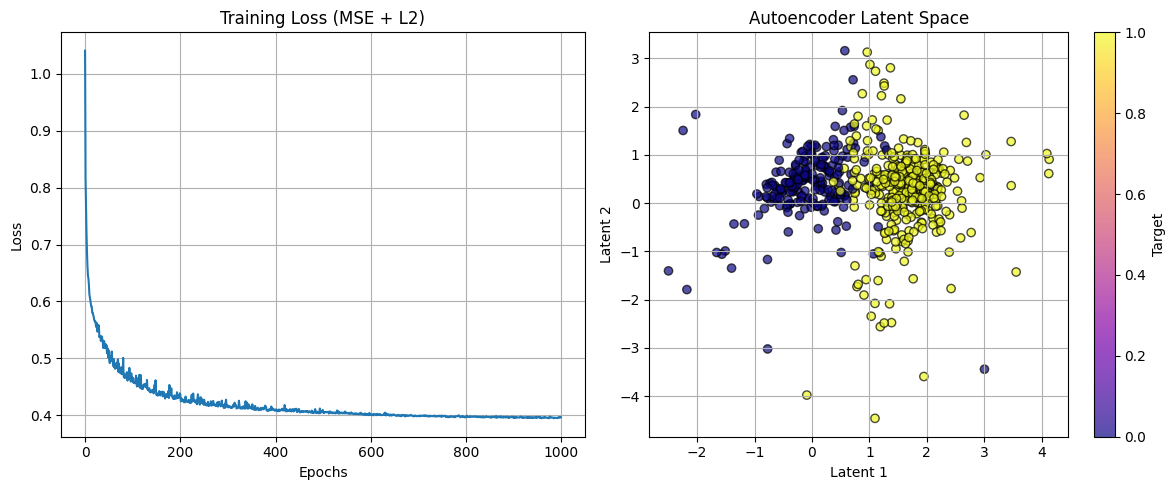

In [6]:
# --- Define Architecture ---
input_dim = X_scaled.shape[1]
latent_dim = CONFIG['bottleneck_dim']

# Structure: 
# Encoder: Input(30) -> 24 -> 16 -> 8 -> Bottleneck(2)
# Decoder: Bottleneck(2) -> 8 -> 16 -> 24 -> Output(30)
# This satisfies the "At least 3 hidden layers in encoder" requirement.
structure = [input_dim, 24, 16, 8, latent_dim, 8, 16, 24, input_dim]

# Activations: Tanh is often stable for deep AE, Linear for final output
activations = ['tanh', 'tanh', 'tanh', 'linear', 'tanh', 'tanh', 'tanh', 'linear']

print(f"Network Structure: {structure}")

# --- Initialize and Train ---
ae = Autoencoder(structure, activations, CONFIG['l2_lambda'])

print("Starting training...")
ae.train(
    X_scaled, 
    epochs=CONFIG['epochs'], 
    batch_size=CONFIG['batch_size'], 
    lr=CONFIG['learning_rate'],
    decay_rate=CONFIG['lr_decay'],
    decay_step=CONFIG['lr_decay_step']
)

# --- Visualization ---
# 1. Loss Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(ae.loss_history)
plt.title('Training Loss (MSE + L2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)

# 2. Latent Space
latent_features = ae.get_latent(X_scaled)
plt.subplot(1, 2, 2)
plt.scatter(latent_features[:, 0], latent_features[:, 1], c=y, cmap='plasma', edgecolor='k', alpha=0.7)
plt.title('Autoencoder Latent Space')
plt.xlabel('Latent 1')
plt.ylabel('Latent 2')
plt.colorbar(label='Target')
plt.grid(True)
plt.tight_layout()
plt.show()